In [1]:
import pandas as pd
import numpy as np
import functools as ft
import itertools as it
import multiprocessing as mp
import scipy.sparse as sp
from go_learning_helpers import *
import itertools
import matplotlib.pyplot as plt
from gensim import corpora
from collections import defaultdict
from gensim.models import TfidfModel
from collections import Counter

%matplotlib notebook

Let's generate a few go_annotation datasets. 

We'll use the original annotations (post-stopwords) binarized, a single-occurence-filtered-out annotations binarized, and a single-occurence-filtered-out tfidf model.

In [2]:
go_file = 'kinase_go_annotations.csv'
go_dir = './'

# get the go annotations
go_annotations = get_go_annotations_series(go_dir+go_file)

# filter out any empty kinases
go_annotations = go_annotations[map(lambda x: len(x) > 0, [x for x in go_annotations])]

# generate binarized go_annotations
go_lab_binner, bin_go_annotations = convert_go_annotations_to_one_hot(go_annotations,
                                                   return_binarizer= True)

# create a frequency chart for every label in the go_annotations 
# this allows us to screen out labels with only one occurence (to help reduce noise)
frequency = defaultdict(int)
for doc in go_annotations:
    for word in doc:
        frequency[word] += 1
texts = [[word for word in doc if frequency[word] > 1]
         for doc in go_annotations]

# generate binarized go_annotations for the intermediate, filtered go_annotations
filter_go_annotations = pd.Series(texts)
filter_go_annotations.index = go_annotations.index
filter_go_annotations.name = go_annotations.name

# filter out any empty filter_kinases
filter_go_annotations = filter_go_annotations[map(lambda x: len(x) > 0, [x for x in filter_go_annotations])]

freq_go_lab_binner, freq_go_annotations = convert_go_annotations_to_one_hot(filter_go_annotations,
                                                   return_binarizer= True)
        
# create a corpus and dictionary (reference) objects for a tfidf model for the go_annotations
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(doc) for doc in texts]

# create a tfidf series for the go_annotations
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# we have to parse gensim's sparse format back into pd.Series format
hold = []
rej = []
for i in range(len(corpus_tfidf)):
    if(len(corpus_tfidf[i]) > 1):
        a, b = map(np.asarray, zip(*corpus_tfidf[i]))
        row = np.repeat(0, len(a))
        hold += [sp.csc_matrix((b, (row, a)), shape=(1,len(dictionary)))]
    else:
        rej += [go_annotations.index[i]]
    

tfidf_go_annotations = pd.Series([x for x in sp.vstack(hold).toarray()])
tfidf_go_annotations.index = [x for x in go_annotations.index.tolist() if x not in rej]
tfidf_go_annotations.name = go_annotations.name

# create a dictionary with our datasets
go_data_dict = {'go':bin_go_annotations,'freq':freq_go_annotations,'tfidf':tfidf_go_annotations }

Now, we need to get our cluster data and make a few DataFrames with the clusters and go_annotations attached

In [7]:
c_spinglass_file = 'consensusclusters_spinglass_greaterthan90percent.txt'
cluster_dir = '../reproduced/'

c_spinglass_data_dict = {key:add_cluster_labels(cluster_dir+c_spinglass_file,
                                  val) for key, val in go_data_dict.items()}

fast_greedy_file = 'fastgreedy_clusters.txt'

fast_greedy_data_dict = {key:add_cluster_labels(cluster_dir+fast_greedy_file,
                                  val) for key, val in go_data_dict.items()}

eigen_file = 'consensusclusters_leadingeigenvector_greaterthan90percent.txt'

eigen_data_dict = {key:add_cluster_labels(cluster_dir+eigen_file,
                                  val) for key, val in go_data_dict.items()}

Dropped  0 kinases due to zero length post-processing
Dropped  1 kinases due to zero length post-processing
Dropped  1 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  1 kinases due to zero length post-processing
Dropped  1 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  1 kinases due to zero length post-processing
Dropped  1 kinases due to zero length post-processing


Now, let's import a few linear classifiers

In [4]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.naive_bayes import ComplementNB as CNB

svm = SVC(kernel='linear')
nb = GNB()
cnb = CNB()

classifiers = [svm, nb, cnb]

And get the accuracy and MCC scores for our datasets

In [8]:
validation_kwargs = {'n_run':20, 'metrics':['accuracy', 'matthews'], 'parallel':3, 'test_size':0.3}
c_spinglass_results = {key+str(clf.__class__).split('.')[-1][0:-2]:validate_learnability(dat_df=val, clf=clf, **validation_kwargs) for key, val in c_spinglass_data_dict.items() for clf in classifiers}
fast_greedy_results = {key+str(clf.__class__).split('.')[-1][0:-2]:validate_learnability(dat_df=val, clf=clf, **validation_kwargs) for key, val in fast_greedy_data_dict.items() for clf in classifiers}
eigen_results = {key+str(clf.__class__).split('.')[-1][0:-2]:validate_learnability(dat_df=val, clf=clf, **validation_kwargs) for key, val in eigen_data_dict.items() for clf in classifiers}

In [26]:
mean_spinglass_results = {key:np.mean(np.vstack(map(np.array, c_spinglass_results[key])), axis=0) for key in c_spinglass_results.keys()}
mean_fast_greedy_results = {key:np.mean(np.vstack(map(np.array, fast_greedy_results[key])), axis=0) for key in fast_greedy_results.keys()}
mean_eigen_results = {key:np.mean(np.vstack(map(np.array, eigen_results[key])), axis=0) for key in eigen_results.keys()}


In [28]:
mean_spinglass_results

{'goSVC': array([0.49894366, 0.40723249]),
 'goGaussianNB': array([0.48838028, 0.40591655]),
 'goComplementNB': array([0.54894366, 0.48166935]),
 'freqSVC': array([0.49260563, 0.40902799]),
 'freqGaussianNB': array([0.48978873, 0.40686191]),
 'freqComplementNB': array([0.56232394, 0.49538121]),
 'tfidfSVC': array([0.5028169 , 0.42523996]),
 'tfidfGaussianNB': array([0.49471831, 0.41180272]),
 'tfidfComplementNB': array([0.54683099, 0.47972294])}

In [29]:
mean_fast_greedy_results

{'goSVC': array([0.56866197, 0.44165752]),
 'goGaussianNB': array([0.54401408, 0.43183396]),
 'goComplementNB': array([0.59647887, 0.4990575 ]),
 'freqSVC': array([0.60140845, 0.48933872]),
 'freqGaussianNB': array([0.57007042, 0.45947007]),
 'freqComplementNB': array([0.60633803, 0.50775761]),
 'tfidfSVC': array([0.59823944, 0.48666786]),
 'tfidfGaussianNB': array([0.56408451, 0.44697864]),
 'tfidfComplementNB': array([0.61443662, 0.5178592 ])}

In [30]:
mean_eigen_results

{'goSVC': array([0.67852113, 0.18676585]),
 'goGaussianNB': array([0.61901408, 0.11293601]),
 'goComplementNB': array([0.57852113, 0.15808657]),
 'freqSVC': array([0.68309859, 0.2042195 ]),
 'freqGaussianNB': array([0.63626761, 0.11418989]),
 'freqComplementNB': array([0.58521127, 0.18843066]),
 'tfidfSVC': array([0.72147887, 0.23462515]),
 'tfidfGaussianNB': array([0.63732394, 0.11943572]),
 'tfidfComplementNB': array([0.58978873, 0.17730761])}

We can see that:

> 1. Leading Eigenvalues does not produce valid clusterings as while accuracy is high, MCC is relatively poor
> 2. Fast Greedy appears to have the best learnability, but we should remeber that Consensus Spinglass has many more classes
> 3. Filtering/TFIDF does not negatively impact the learnability, so we can ignore the rare labels in our analysis


In [35]:
c_spinglass_X, __, c_spinglass_y, __ = get_tts(dat=c_spinglass_data_dict['freq'],test_size=0)

In [80]:
svm = SVC(kernel='linear')
svm.fit(c_spinglass_X, c_spinglass_y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [53]:
feat = freq_go_lab_binner.classes_.tolist()

In [97]:
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

In [114]:
def f_importances(coef, names, top=20):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    imp_down, names_down = zip(*list(zip(imp, names))[0:top])
    imp_up, names_up = zip(*list(zip(imp, names))[-top:])
    plt.yticks(range(2*top), names_up+names_down)
    plt.barh(range(top, 2*top), imp_up, align='center')
    plt.barh(range(top), imp_down, align='center')
    plt.show()

(n_samples, n_classes * (n_classes - 1) / 2)

In [76]:
svm.decision_function_shape

'ovr'

In [69]:
57 * (57-1)/2

1596.0

In [79]:
svm.coef_.shape

(1596, 1850)

In [125]:
c_spinglass_data_dict['freq'][c_spinglass_data_dict['freq']['cluster'] == 0]

,cluster,GO Labels
names,,
INSR,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
INSRR,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
SIK2,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


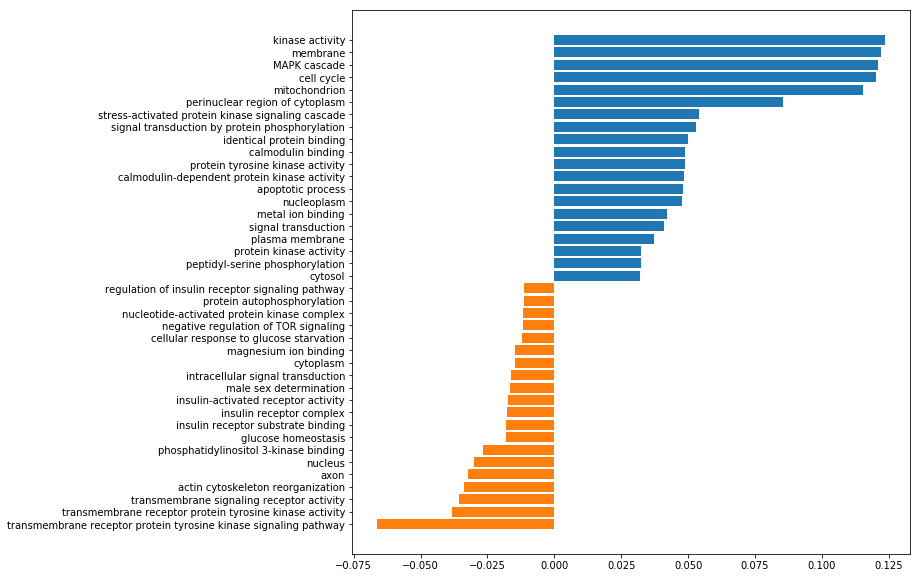

In [123]:
fig, ax = plt.subplots(figsize=(10,10))
f_importances(coef=np.mean(svm.coef_[:56,:], axis=0), names=feat)